# Import Libraries and Dataset

In [1]:
# Numpy and Pandas
import numpy as np
import pandas as pd

# Plotly Packages
from chart_studio import plotly
import plotly.express as px 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Country Names into Alpha Codes
import pycountry

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', 
                 names = ['Date', 'Avg Temperature', 'Avg Temperature Uncertainty', 'Country'], 
                 header=0)

### Convert Date to Datetime Object

In [3]:
df['Date']=pd.to_datetime(df['Date'])

In [4]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

The dataset is currently way too big and will end up complicating the choropleth map. Therefore I have decided to use data from every five years rather than every single year. Moreover, actual dataset contains monthly readings which will make the choropleth much more confusing as the legend will keep changing. That is why I will only use data from the month of March

In [5]:
df = df[df['Month']==3]
df = df[df['Year']%5==0]

How much missing data do we have?

<AxesSubplot:>

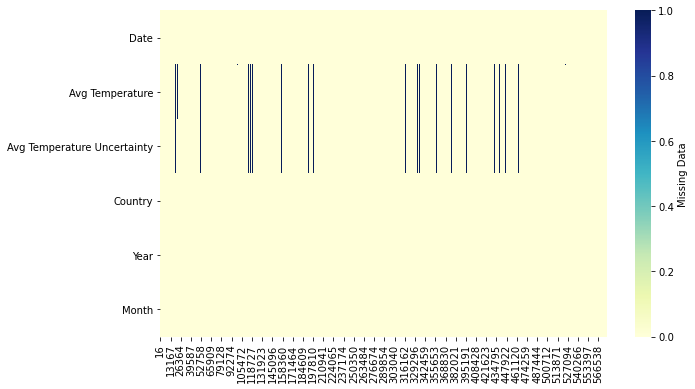

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

# Plan of Action

There are two ways we can map the data. 

1- we can plot a figure object using the plot() method. Won't need to convert country names to alpha 3 codes but we won't be able to get an animation from this method.

2- Use plotly.express to create the choropleth maps. Can create an animation but will have to do some feature engineering

# Method 1:

In [7]:
#color scale for the plot:

scl = [[0.0, '#ffffff'],[0.2, '#ff9999'],[0.4, '#ff4d4d'], \
       [0.6, '#ff1a1a'],[0.8, '#cc0000'],[1.0, '#4d0000']] # reds




### create empty list for the data slider:    

data_slider = []

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'

for year in df.Year.unique():


    # For each year:
    df_sected = df[df['Year']== year]

    for col in df_sected.columns:  # Transform the columns into string type
        df_sected[col] = df_sected[col].astype(str)

    # create a dictionary with the data for the current year
    data_one_year = dict(
                        type='choropleth',
                        locations = df_sected['Country'],
                        z=df_sected['Avg Temperature'],
                        locationmode='country names',
                        colorscale = scl,
                        colorbar = {'title':'Avg. Global Temperature'}
                        )

    data_slider.append(data_one_year)  # Append data to the data slider list




In [9]:
# Create the steps and sliders objetcs:

steps = []

for i in range(len(data_slider)):
    j = i * 5
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='Year {}'.format(j + 1745)) # label to be displayed for each step (year)
    step['args'][1][i] = True
    steps.append(step)


sliders = [dict(active=0, pad={"t": 1}, steps=steps)]  

In [10]:
# Setting up the layout (including slider option)

layout = dict(title = 'Climate Change Analysis <br> Avg. Global Temperature <br> (1745-2010)',
              geo=dict(scope='world',
                       projection = {'type':'mercator'}),
              sliders=sliders)



# Creating the figure object:

fig = dict(data=data_slider, layout=layout) 




# to plot in the notebook

iplot(fig)




# to plot in a separate browser window

plot(fig,validate=False) 

'temp-plot.html'

# Method 2 - plotly.express

Requires us to use the pycountry library. 

One problem is that some of the country names in the dataset do not match the official names, for example Russia should be Russian Federation. Will change Russia as that is a big one but we will ignore the smaller names for now.

In [11]:
df['Country'] = df['Country'].str.replace('Russia','Russian Federation')

In [12]:
def findCountry (country_name):
    try:
        return pycountry.countries.get(name=country_name).alpha_3
    except:
        return 
df['Alpha 3 Code'] = df.apply(lambda row: findCountry(row.Country) , axis = 1)

In [106]:
import plotly.express as px

scl = [[0.0, '#ffffff'],[0.2, '#ff9999'],[0.4, '#ff4d4d'], \
       [0.6, '#ff1a1a'],[0.8, '#cc0000'],[1.0, '#4d0000']] # reds

plot(px.choropleth(df,               
              locations="Alpha 3 Code",               
              color="Avg Temperature",
              hover_name="Country",  
              animation_frame="Year",
              projection='mercator',
              color_continuous_scale=scl, 
              title='Average Temperature of Countries (Recorded in the Month of March) <br> (1745-2010)',
              width=1300,
              height=700
))

"""
px.choropleth(df,               
              locations="Alpha 3 Code",               
              color="Avg Temperature",
              hover_name="Country",  
              animation_frame="Year",
              projection='mercator',
              color_continuous_scale=scl, 
              title='Average Temperature of Countries Recorded in March <br> (1745-2010)',
              width=1300,
              height=700
)
"""

'\npx.choropleth(df,               \n              locations="Alpha 3 Code",               \n              color="Avg Temperature",\n              hover_name="Country",  \n              animation_frame="Year",\n              projection=\'mercator\',\n              color_continuous_scale=scl, \n              title=\'Average Temperature of Countries Recorded in March <br> (1745-2010)\',\n              width=1300,\n              height=700\n)\n'

# Observations

1- By looking at the map over time, it seems evident that the temperature keeps fluctuating across time. If we focus on individual countries, there does not seem to be a trend where the temperature keeps rising across time uniformely. 

2- The problem with this dataset is that many of these countries are incredibly large with a wide variety of weathers and geographies. Ho
wever only one 'average' temperature is reported per country. Therefore it is difficult to make out any clear trends, since perhaps the colder mountainous areas may have been getting colder and the hotter areas are getting hotter, but the average temperature remains constant. Hard to rule this scenario out.

3- It would be interesting to focus on individual countries, perhaps really small countries or countries that are reported to be worst hit by climate change and see whether we can distinguish a pattern in the temperature. It would also be interesting to perhaps rank the countries in terms of least affected by climate change to most affected. From then we can look for similarities between the countries and define some of the variables that affect a country's susceptibility to climate change.

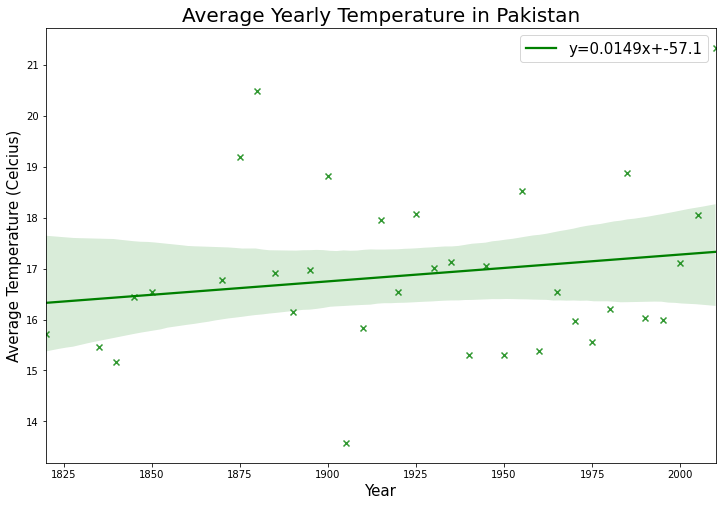

In [90]:
pak = df[df['Country']=='Pakistan']

from scipy import stats

#slope, intercept, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float),pak['Avg Temperature'])

mask = ~np.isnan(pak['Year'].astype(float)) & ~np.isnan(pak['Avg Temperature'])
slope_pk, intercept_pk, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float)[mask],pak['Avg Temperature'][mask])

plt.figure(figsize=(12,8))
ax = sns.regplot(x='Year', y = 'Avg Temperature', data=pak,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope,intercept)}, marker='x', color='g')

plt.ylabel('Average Temperature (Celcius)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Average Yearly Temperature in Pakistan', fontsize=20)

ax.legend(fontsize=15)


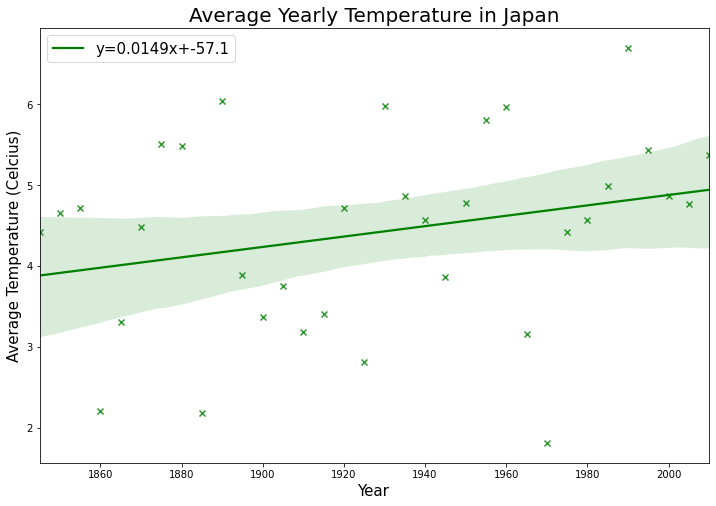

In [91]:
jap = df[df['Country']=='Japan']

from scipy import stats

#slope, intercept, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float),pak['Avg Temperature'])

mask = ~np.isnan(jap['Year'].astype(float)) & ~np.isnan(jap['Avg Temperature'])
slope_jp, intercept_jp, r_value, p_value, std_err = stats.linregress(jap['Year'].astype(float)[mask],jap['Avg Temperature'][mask])

plt.figure(figsize=(12,8))
ax = sns.regplot(x='Year', y = 'Avg Temperature', data=jap,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope,intercept)}, marker='x', color='g')

plt.ylabel('Average Temperature (Celcius)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Average Yearly Temperature in Japan', fontsize=20)

ax.legend(fontsize=15)




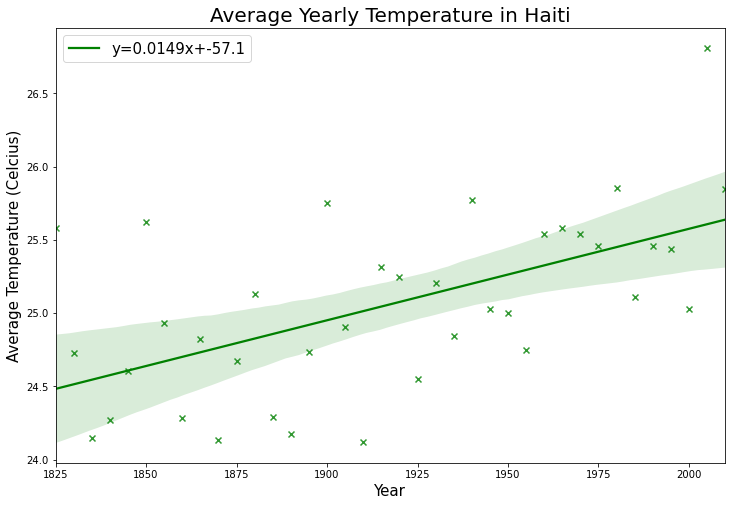

In [92]:
haiti = df[df['Country']=='Haiti']

from scipy import stats

#slope, intercept, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float),pak['Avg Temperature'])

mask = ~np.isnan(haiti['Year'].astype(float)) & ~np.isnan(haiti['Avg Temperature'])
slope_hai, intercept_hai, r_value, p_value, std_err = stats.linregress(haiti['Year'].astype(float)[mask],haiti['Avg Temperature'][mask])

plt.figure(figsize=(12,8))
ax = sns.regplot(x='Year', y = 'Avg Temperature', data=haiti,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope,intercept)}, marker='x', color='g')

plt.ylabel('Average Temperature (Celcius)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Average Yearly Temperature in Haiti', fontsize=20)

ax.legend(fontsize=15)


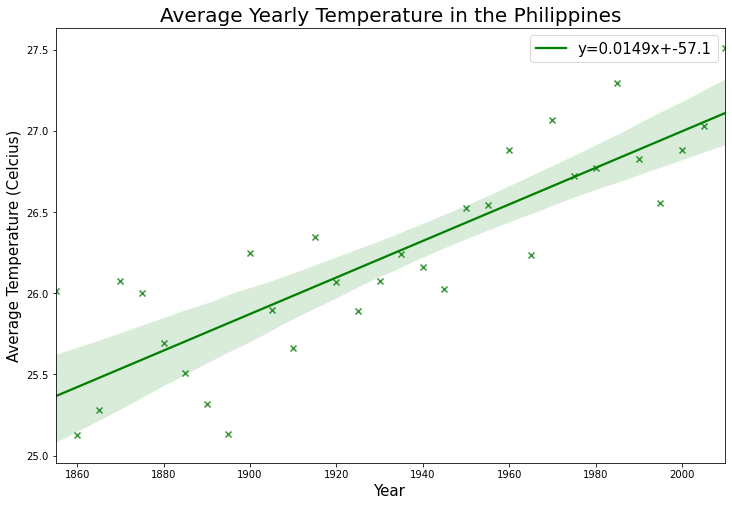

In [93]:
phi = df[df['Country']=='Philippines']

from scipy import stats

#slope, intercept, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float),pak['Avg Temperature'])

mask = ~np.isnan(phi['Year'].astype(float)) & ~np.isnan(phi['Avg Temperature'])
slope_phi, intercept_phi, r_value, p_value, std_err = stats.linregress(phi['Year'].astype(float)[mask],phi['Avg Temperature'][mask])

plt.figure(figsize=(12,8))
ax = sns.regplot(x='Year', y = 'Avg Temperature', data=phi,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope,intercept)}, marker='x', color='g')

plt.ylabel('Average Temperature (Celcius)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Average Yearly Temperature in the Philippines', fontsize=20)

ax.legend(fontsize=15)




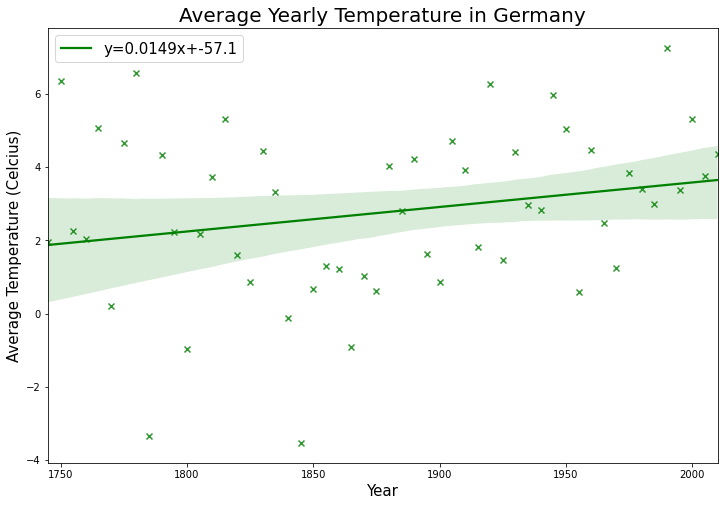

In [94]:
ger = df[df['Country']=='Germany']

from scipy import stats

#slope, intercept, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float),pak['Avg Temperature'])

mask = ~np.isnan(ger['Year'].astype(float)) & ~np.isnan(ger['Avg Temperature'])
slope_ger, intercept_ger, r_value, p_value, std_err = stats.linregress(ger['Year'].astype(float)[mask],ger['Avg Temperature'][mask])

plt.figure(figsize=(12,8))
ax = sns.regplot(x='Year', y = 'Avg Temperature', data=ger,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope,intercept)}, marker='x', color='g')

plt.ylabel('Average Temperature (Celcius)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Average Yearly Temperature in Germany', fontsize=20)

ax.legend(fontsize=15)

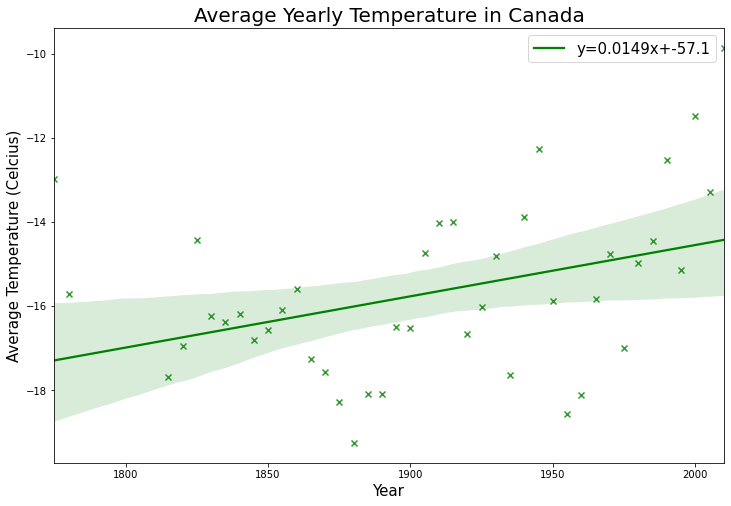

In [95]:
can = df[df['Country']=='Canada']

from scipy import stats

#slope, intercept, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float),pak['Avg Temperature'])

mask = ~np.isnan(can['Year'].astype(float)) & ~np.isnan(can['Avg Temperature'])
slope_can, intercept_can, r_value, p_value, std_err = stats.linregress(can['Year'].astype(float)[mask],can['Avg Temperature'][mask])

plt.figure(figsize=(12,8))
ax = sns.regplot(x='Year', y = 'Avg Temperature', data=can,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope,intercept)}, marker='x', color='g')

plt.ylabel('Average Temperature (Celcius)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Average Yearly Temperature in Canada', fontsize=20)

ax.legend(fontsize=15)

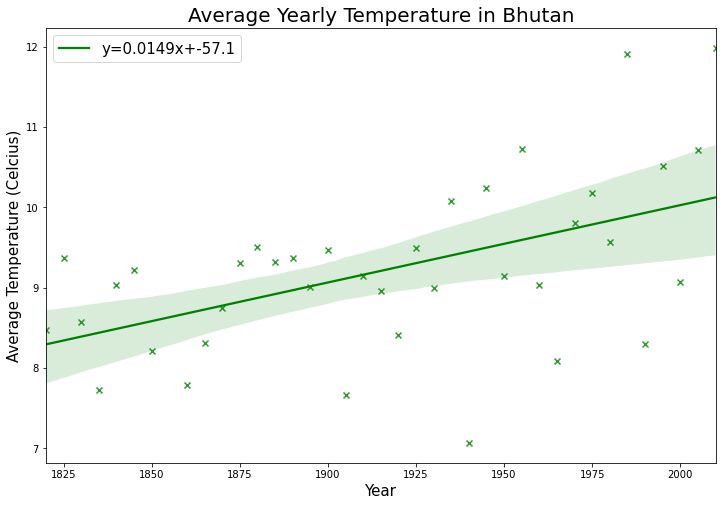

In [96]:
bhu = df[df['Country']=='Bhutan']

from scipy import stats

#slope, intercept, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float),pak['Avg Temperature'])

mask = ~np.isnan(bhu['Year'].astype(float)) & ~np.isnan(bhu['Avg Temperature'])
slope_bhu, intercept_bhu, r_value, p_value, std_err = stats.linregress(bhu['Year'].astype(float)[mask],bhu['Avg Temperature'][mask])

plt.figure(figsize=(12,8))
ax = sns.regplot(x='Year', y = 'Avg Temperature', data=bhu,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope,intercept)}, marker='x', color='g')

plt.ylabel('Average Temperature (Celcius)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Average Yearly Temperature in Bhutan', fontsize=20)

ax.legend(fontsize=15)

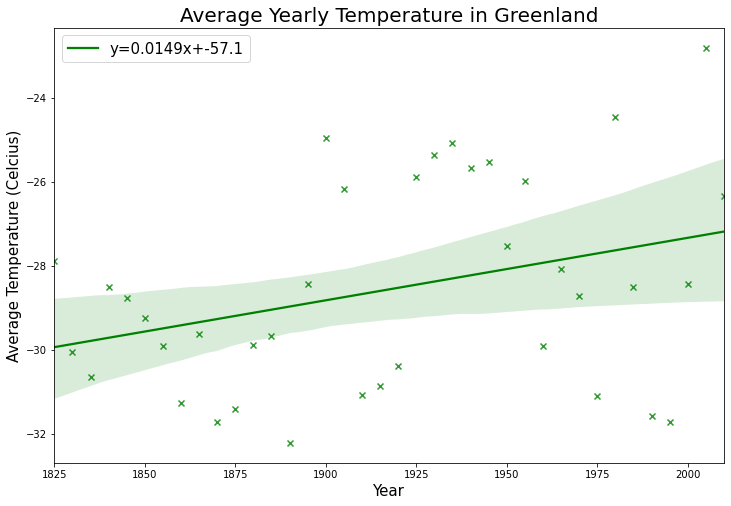

In [97]:
gre = df[df['Country']=='Greenland']

from scipy import stats

#slope, intercept, r_value, p_value, std_err = stats.linregress(pak['Year'].astype(float),pak['Avg Temperature'])

mask = ~np.isnan(gre['Year'].astype(float)) & ~np.isnan(gre['Avg Temperature'])
slope_gre, intercept_gre, r_value, p_value, std_err = stats.linregress(gre['Year'].astype(float)[mask],gre['Avg Temperature'][mask])

plt.figure(figsize=(12,8))
ax = sns.regplot(x='Year', y = 'Avg Temperature', data=gre,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope,intercept)}, marker='x', color='g')

plt.ylabel('Average Temperature (Celcius)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Average Yearly Temperature in Greenland', fontsize=20)

ax.legend(fontsize=15)

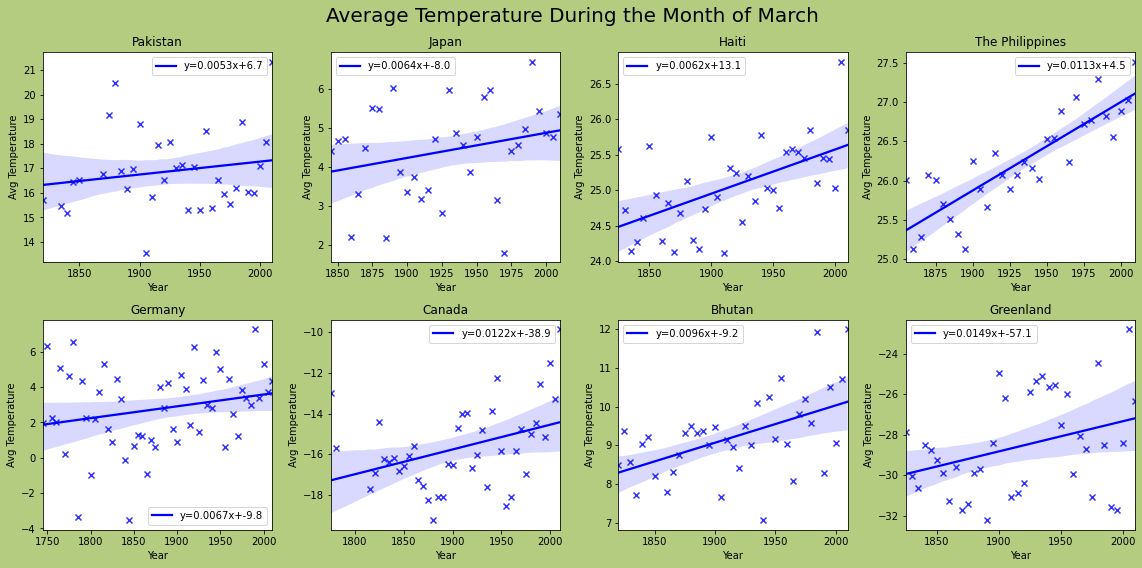

In [108]:
fig, axes = plt.subplots(2, 4, sharex=False, figsize=(16,8))
fig.suptitle('Average Temperature During the Month of March', fontsize=20)

ax1 = sns.regplot(ax=axes[0, 0], x='Year', y = 'Avg Temperature', data=pak,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope_pk,intercept_pk)}, marker='x', color='b')
ax1.legend(fontsize=10)
ax1.title.set_text('Pakistan')

ax2 = sns.regplot(ax=axes[0, 1], x='Year', y = 'Avg Temperature', data=jap,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope_jp,intercept_jp)}, marker='x', color='b')
ax2.legend(fontsize=10)
ax2.title.set_text('Japan')

ax3 = sns.regplot(ax=axes[0, 2], x='Year', y = 'Avg Temperature', data=haiti,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope_hai,intercept_hai)}, marker='x', color='b')
ax3.legend(fontsize=10)
ax3.title.set_text('Haiti')

ax4 = sns.regplot(ax=axes[0, 3], x='Year', y = 'Avg Temperature', data=phi,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope_phi,intercept_phi)}, marker='x', color='b')
ax4.legend(fontsize=10)
ax4.title.set_text('The Philippines')

ax5 = sns.regplot(ax=axes[1, 0], x='Year', y = 'Avg Temperature', data=ger,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope_ger,intercept_ger)}, marker='x', color='b')
ax5.legend(fontsize=10)
ax5.title.set_text('Germany')

ax6 = sns.regplot(ax=axes[1, 1], x='Year', y = 'Avg Temperature', data=can,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope_can,intercept_can)}, marker='x', color='b')
ax6.legend(fontsize=10)
ax6.title.set_text('Canada')

ax7 = sns.regplot(ax=axes[1, 2], x='Year', y = 'Avg Temperature', data=bhu,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope_bhu,intercept_bhu)}, marker='x', color='b')
ax7.legend(fontsize=10)
ax7.title.set_text('Bhutan')

ax8 = sns.regplot(ax=axes[1, 3], x='Year', y = 'Avg Temperature', data=gre,
           line_kws={'label':"y={0:.4f}x+{1:.1f}".format(slope_gre,intercept_gre)}, marker='x', color='b')
ax8.legend(fontsize=10)
ax8.title.set_text('Greenland')

plt.tight_layout()

fig.set_facecolor((0.7,0.8,0.5))

plt.savefig('climate_change.png',dpi=1200)

# Final Remarks/Comments

1- It seems that the climate does change over time and there are natural fluctuations associated with the temperature. 

2- It is unfair to use this dataset to definitively prove whether climate change is happening since there is only one 'average' temperature reading provided for each country. Many countries are large and vast and contain a wide range of climates and geographies. It is tough to draw insights when all of them are clumped together and only a single average value is provided.

3- Despite the limitations of the dataset, it can be seen, especially when we zoom in and focus on individual countries, that the average temperature of countries across time seems to be rising. We can see in the above subplots that each of the lmplots have a positive slope value. 

4- According to Iberdrola (https://www.iberdrola.com/environment/top-countries-most-affected-by-climate-change), the countries most affected by climate change are Japan, the Philippines and Germany. However, just judging solely from this dataset, we can see that some other countries such as Greenland and Canada have an even higher slope than the top 3 countries. 

5- The Philippines is perhaps the best example to prove that climate change is happening. We can see that there is very limited noise and we can see a clear upwards trend in the temperature across time.